In [1]:
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

In [18]:
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective += mdl.sum(
        [sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    )
    mdl.minimize(objective)
#     cost = mdl.sum(x)
#     mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp


def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [19]:
h = np.array([396, 752, 1204, 1177])
d = np.array([1040, 2480, 7960, 3230])
T = 5
M = 1000.0

# h = np.array([870, 2501, 4478, 1777, 2970])
# d = np.array([2700, 6500, 15000, 100, 10000])
# T = 13.5
# M = 1000

t = h/(M/2.0) + d/(5.0*M)
print(t)
Q = np.outer(t, t)
print(Q)
b = -2.0 * T * t
# print(b)
# Q = Q + np.diag(b)
# print(Q)

[1. 2. 4. 3.]
[[ 1.  2.  4.  3.]
 [ 2.  4.  8.  6.]
 [ 4.  8. 16. 12.]
 [ 3.  6. 12.  9.]]


Classical Cplex Optimizer. ILP (Integer Linear Programming) first.

In [20]:
qubo = create_problem(b, Q)
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model5

Minimize
 obj: - 10 x0 - 20 x1 - 40 x2 - 30 x3 + [ 2 x0^2 + 8 x0*x1 + 16 x0*x2 + 12 x0*x3
      + 8 x1^2 + 32 x1*x2 + 24 x1*x3 + 32 x2^2 + 48 x2*x3 + 18 x3^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End

In [21]:
CplexOptimizer().solve(qubo)

optimal function value: -25.0
optimal value: [0. 1. 0. 1.]
status: SUCCESS

Still Classical, but linear programming (relaxed).

In [22]:
qp = relax_problem(QuadraticProgramToQubo().convert(qubo))
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model5

Minimize
 obj: - 10 x0 - 20 x1 - 40 x2 - 30 x3 + [ 2 x0^2 + 8 x0*x1 + 16 x0*x2 + 12 x0*x3
      + 8 x1^2 + 32 x1*x2 + 24 x1*x3 + 32 x2^2 + 48 x2*x3 + 18 x3^2 ]/2
Subject To

Bounds
       x0 <= 1
       x1 <= 1
       x2 <= 1
       x3 <= 1
End

In [23]:
sol = CplexOptimizer().solve(qp)
sol

optimal function value: -25.0
optimal value: [1.  1.  0.5 0. ]
status: SUCCESS

In [24]:
c_stars = sol.samples[0].x
c_stars

[1.0, 1.0, 0.5000000000000002, 0]

QAOA

In [25]:
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 1.0])
exact_mes = NumPyMinimumEigensolver()

In [26]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [27]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

optimal function value: -25.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


In [28]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        if sum(s.x) == 3:
            qaoa_res.append(("".join([str(int(_)) for _ in s.x]), s.fval, s.probability))

    res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]

    return [(_[0] + f": value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%") for _ in res]


format_qaoa_samples(qaoa_result.samples)

['0111: value: -9.000, probability: 3.2%',
 '1011: value: -16.000, probability: 5.9%',
 '1110: value: -21.000, probability: 13.6%',
 '1101: value: -24.000, probability: 1.5%']

Warm start QAOA, rotation on each qubit depending on the LP solution.

In [30]:
from qiskit import QuantumCircuit

thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(len(Q))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl")

<Figure size 203.885x367.889 with 1 Axes>

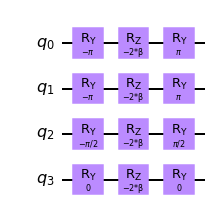

In [32]:
from qiskit.circuit import Parameter

beta = Parameter("β")

ws_mixer = QuantumCircuit(len(Q))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

In [34]:
ws_qaoa_mes = QAOA(
    quantum_instance=quantum_instance,
    initial_state=init_qc,
    mixer=ws_mixer,
    initial_point=[0.0, 1.0],
)
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)
ws_qaoa_result = ws_qaoa.solve(qubo)
print(ws_qaoa_result)
format_qaoa_samples(ws_qaoa_result.samples)

optimal function value: -21.0
optimal value: [1. 1. 0. 0.]
status: SUCCESS


['1110: value: -21.000, probability: 50.0%']